In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [9]:
train_data = train_datagen.flow_from_directory(
    "Training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    "Testing",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


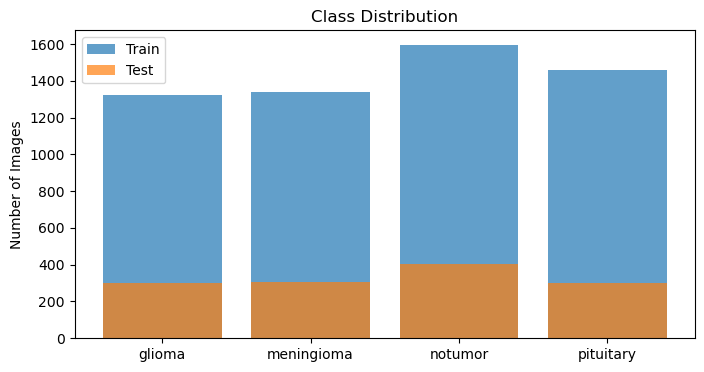

In [62]:
from collections import Counter

train_count = Counter(train_data.classes)
test_count = Counter(test_data.classes)
classes = list(train_data.class_indices.keys())

plt.figure(figsize=(8,4))
plt.bar(classes, train_count.values(), alpha=0.7, label='Train')
plt.bar(classes, test_count.values(), alpha=0.7, label='Test')
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


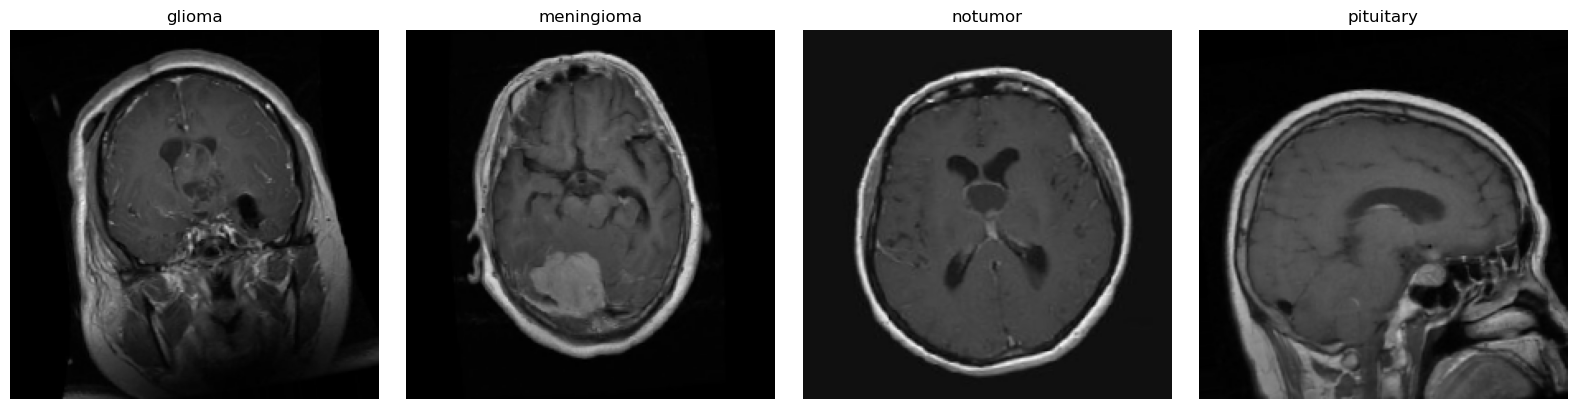

In [61]:
def show_one_image_per_class(data_generator):
    class_names = list(data_generator.class_indices.keys())
    num_classes = len(class_names)

    found = {i: False for i in range(num_classes)}
    images_per_class = {}

    while len(images_per_class) < num_classes:
        images, labels = next(data_generator)

        for img, label in zip(images, labels):
            class_idx = np.argmax(label)

            if not found[class_idx]:
                images_per_class[class_idx] = img
                found[class_idx] = True

            if len(images_per_class) == num_classes:
                break

    plt.figure(figsize=(4 * num_classes, 4))
    for i, class_name in enumerate(class_names):
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(images_per_class[i])
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_one_image_per_class(train_data)


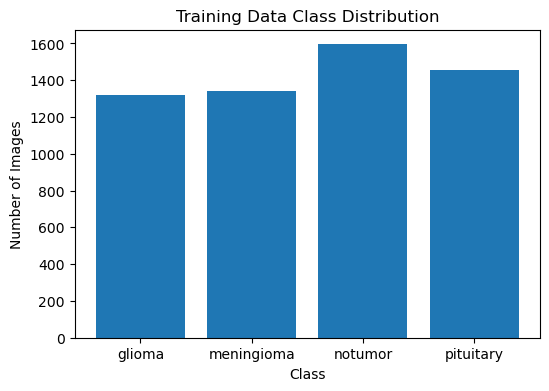

In [69]:
import collections

counter = collections.Counter(train_data.classes)
class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(6,4))
plt.bar(class_names, counter.values())
plt.title("Training Data Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [10]:
model = Sequential([

    # 🔹 Block 1
    Conv2D(32, (3,3), activation='relu',
           kernel_regularizer=l2(0.001),
           input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    # 🔹 Block 2
    Conv2D(64, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(),

    # 🔹 Block 3
    Conv2D(128, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(),

    # 🔹 Block 4
    Conv2D(256, (3,3), activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(),

    # 🔹 Classifier
    Flatten(),
    Dense(256, activation='relu',
          kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,828,804 (37.49 MB)

 Trainable params: 9,827,844 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [13]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    callbacks=callbacks
)


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 133s 723ms/step - accuracy: 0.6901 - loss: 1.7261 - val_accuracy: 0.2342 - val_loss: 7.4164 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 686ms/step - accuracy: 0.7719 - loss: 1.3852 - val_accuracy: 0.6262 - val_loss: 1.7283 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 692ms/step - accuracy: 0.8107 - loss: 1.2715 - val_accuracy: 0.7941 - val_loss: 1.2394 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 683ms/step - accuracy: 0.8351 - loss: 1.1995 - val_accuracy: 0.8604 - val_loss: 1.0613 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 684ms/step - accuracy: 0.8491 - loss: 1.1379 - val_accuracy: 0.7750 - val_loss: 1.2971 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 686ms/step - accuracy: 0.8594 - loss: 1.0888 - val_accuracy: 0.8459 - val_loss: 1.0605 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9184 - loss: 0.6873
Test Accuracy: 0.9184


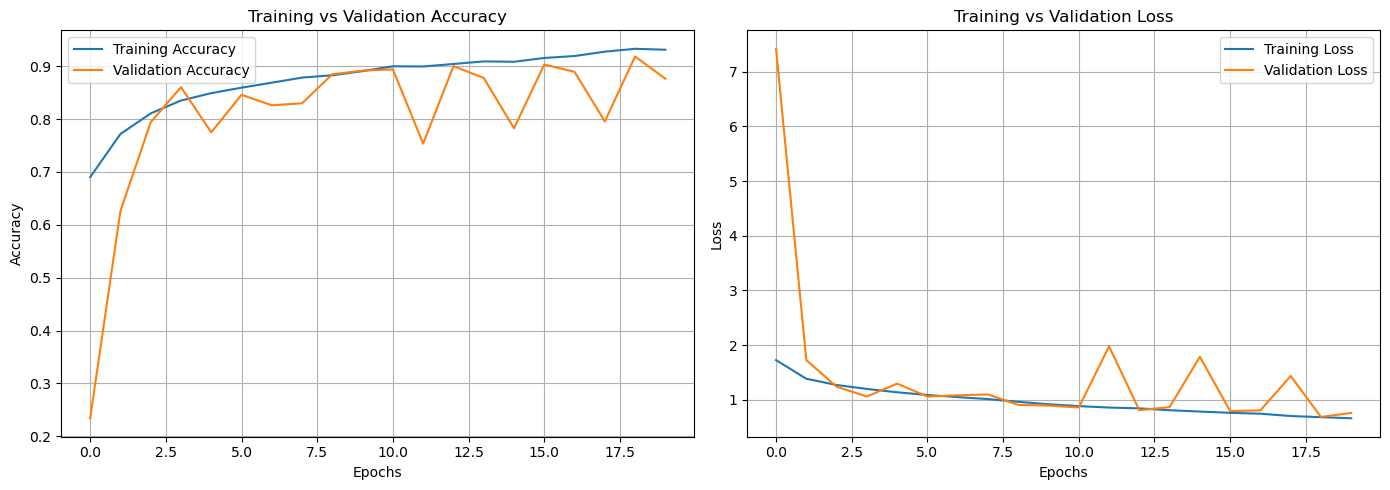

In [29]:
# =========================
# Accuracy & Loss Plots
# =========================
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9184 - loss: 0.6873
Test Accuracy: 0.9184
Test Loss: 0.6873


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


<Figure size 600x600 with 0 Axes>

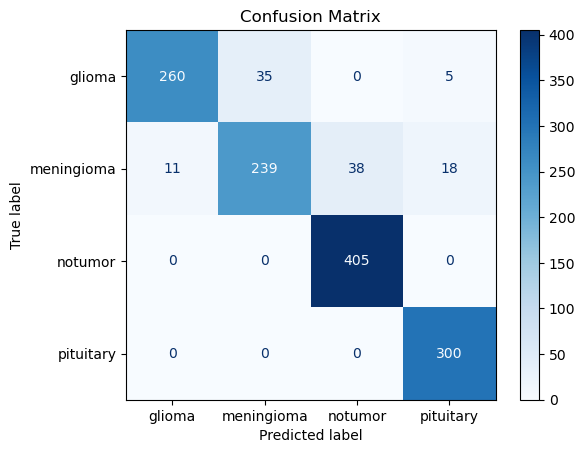

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [53]:
def show_predictions_random(test_data, model, class_names, num=9):
    # Get all images & labels
    images, labels = [], []

    for i in range(len(test_data)):
        batch_imgs, batch_lbls = test_data[i]
        images.append(batch_imgs)
        labels.append(batch_lbls)

    images = np.concatenate(images)
    labels = np.concatenate(labels)

    # Randomly select samples
    idx = np.random.choice(len(images), num, replace=False)

    preds = model.predict(images[idx])

    plt.figure(figsize=(10,10))
    for i, id in enumerate(idx):
        plt.subplot(3,3,i+1)
        plt.imshow(images[id])
        true = class_names[np.argmax(labels[id])]
        pred = class_names[np.argmax(preds[i])]
        plt.title(f"True: {true}\nPred: {pred}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


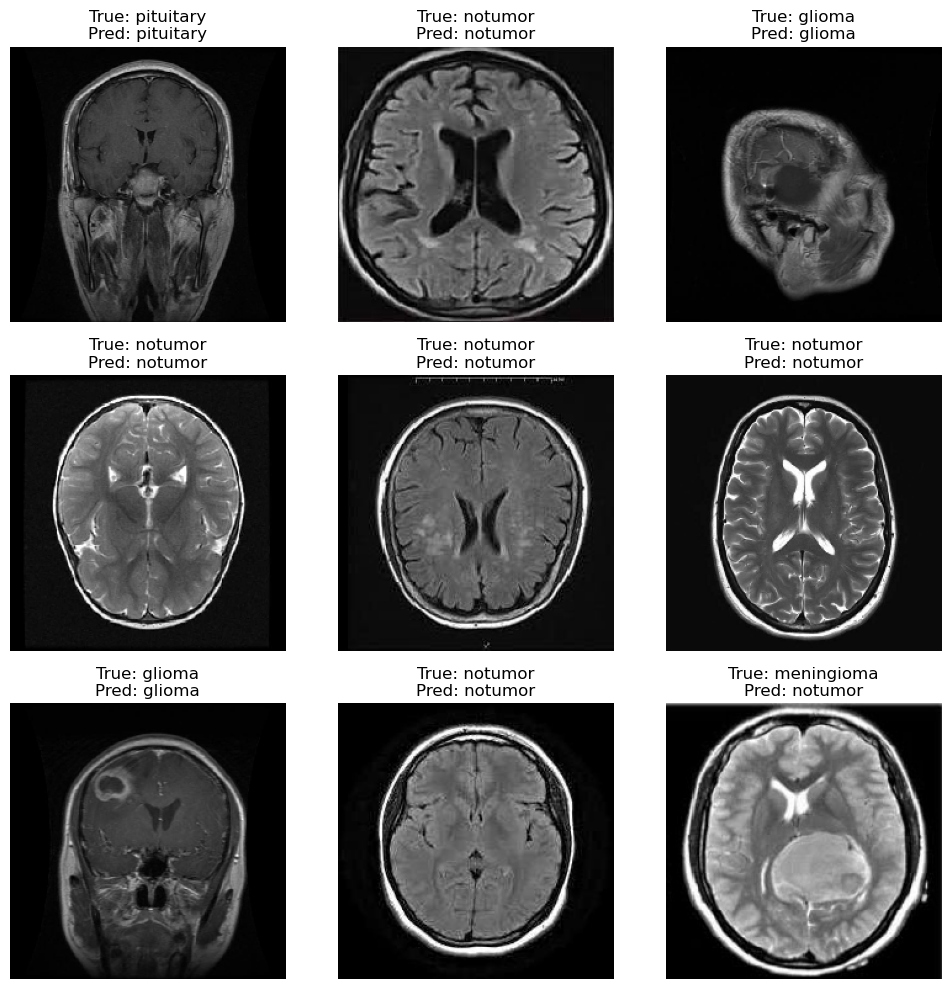

In [54]:
class_names = list(train_data.class_indices.keys())
show_predictions_random(test_data, model, class_names)


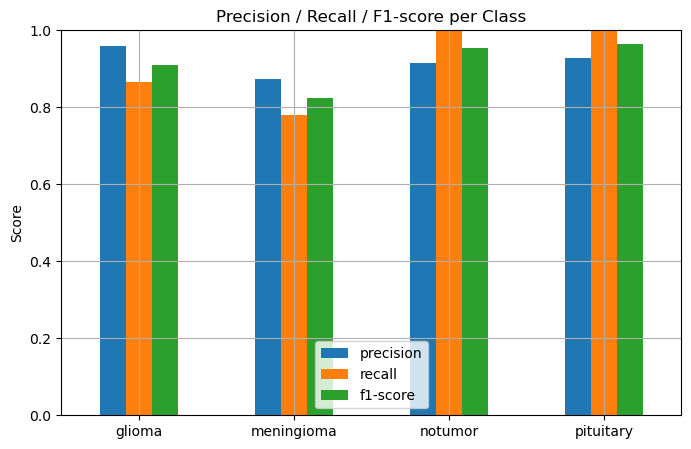

In [68]:
import pandas as pd

df = pd.DataFrame(report).T

# Remove non-class rows safely
df = df.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Keep only metrics we want
df = df[['precision', 'recall', 'f1-score']]

# Plot
df.plot(kind='bar', figsize=(8,5))
plt.title("Precision / Recall / F1-score per Class")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


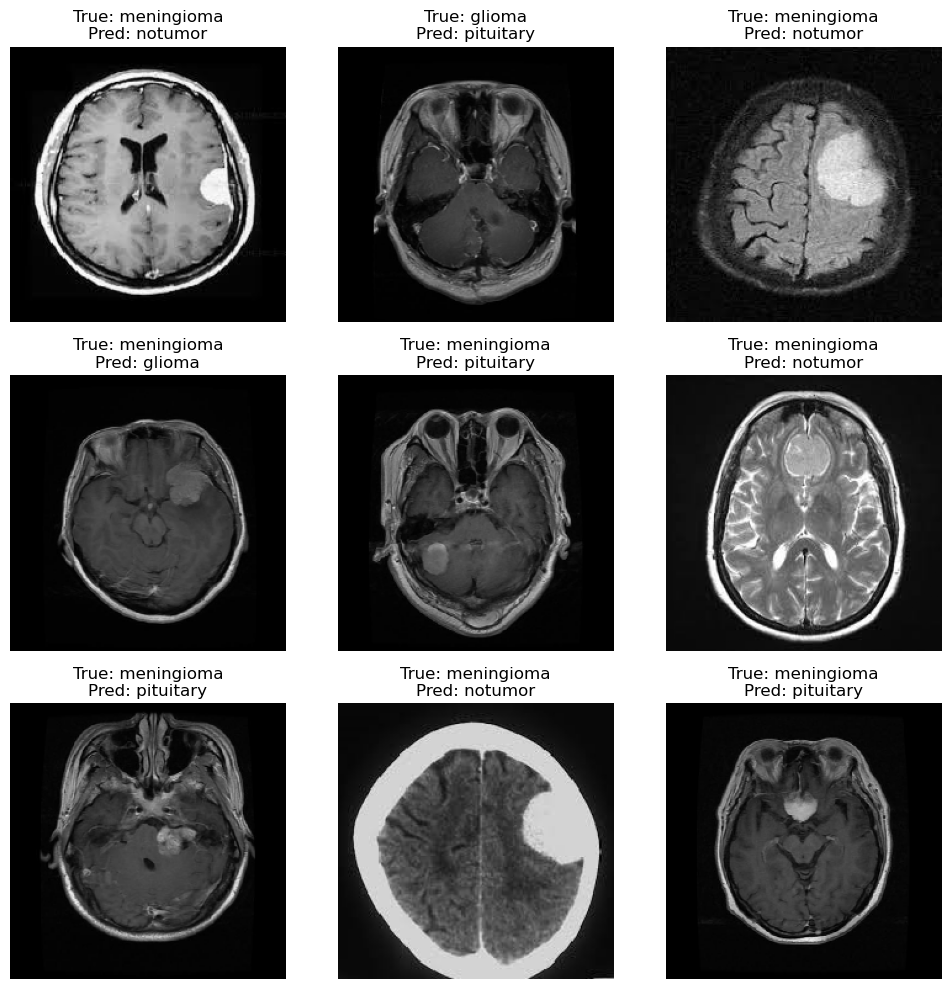

In [60]:
def show_wrong_predictions(test_data, model, class_names, num=9):
    images, labels = [], []

    for i in range(len(test_data)):
        x, y = test_data[i]
        images.append(x)
        labels.append(y)

    images = np.concatenate(images)
    labels = np.concatenate(labels)

    preds = np.argmax(model.predict(images), axis=1)
    true = np.argmax(labels, axis=1)

    wrong_idx = np.where(preds != true)[0]
    selected = np.random.choice(wrong_idx, min(num, len(wrong_idx)), replace=False)

    plt.figure(figsize=(10,10))
    for i, idx in enumerate(selected):
        plt.subplot(3,3,i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true[idx]]}\nPred: {class_names[preds[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


class_names = list(train_data.class_indices.keys())
show_wrong_predictions(test_data, model, class_names)


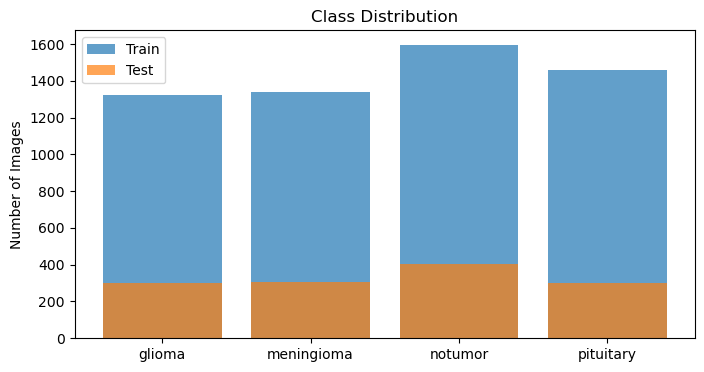

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step


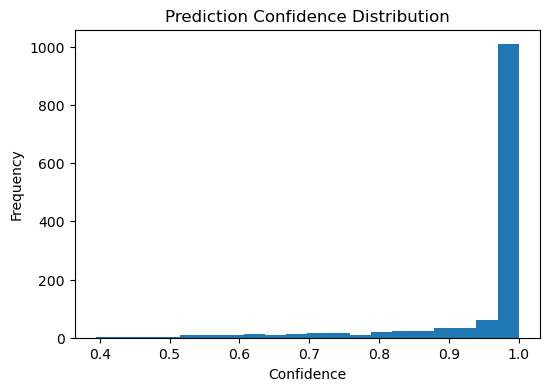

In [70]:
pred_probs = model.predict(test_data)
confidence = np.max(pred_probs, axis=1)

plt.figure(figsize=(6,4))
plt.hist(confidence, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()
